In [1]:
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
from tensorflow import keras

In [2]:
(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()

print(X_train.shape, X_train.dtype)
print(Y_train.shape, Y_train.dtype)
print(X_test.shape, X_test.dtype)
print(Y_test.shape, Y_test.dtype)

(60000, 28, 28) uint8
(60000,) uint8
(10000, 28, 28) uint8
(10000,) uint8


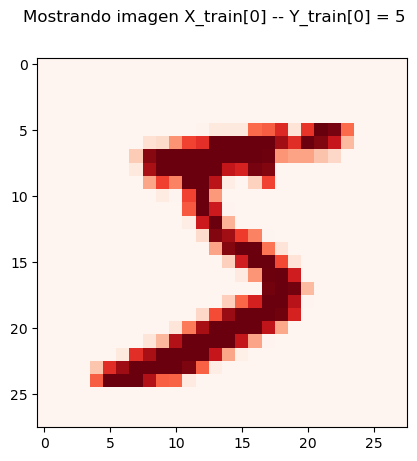

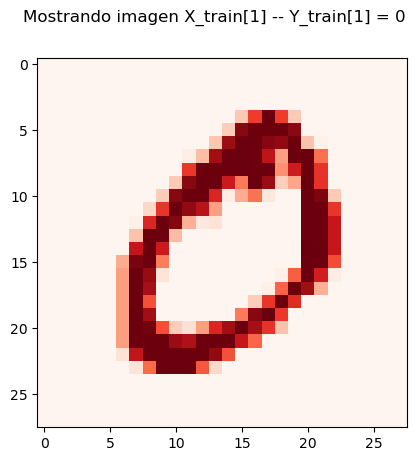

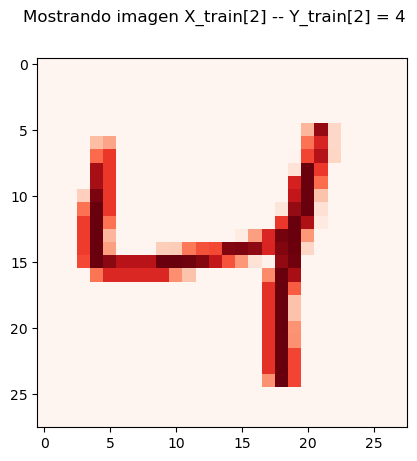

In [3]:
import matplotlib.pyplot as plt

def show_image(imagen, title):
    plt.figure()
    plt.suptitle(title)
    plt.imshow(imagen, cmap = "Reds")
    plt.show()
    
for i in range(3):
    title = "Mostrando imagen X_train[" + str(i) + "]"
    title = title + " -- Y_train[" + str(i) + "] = " + str(Y_train[i])
    show_image(X_train[i], title)

1


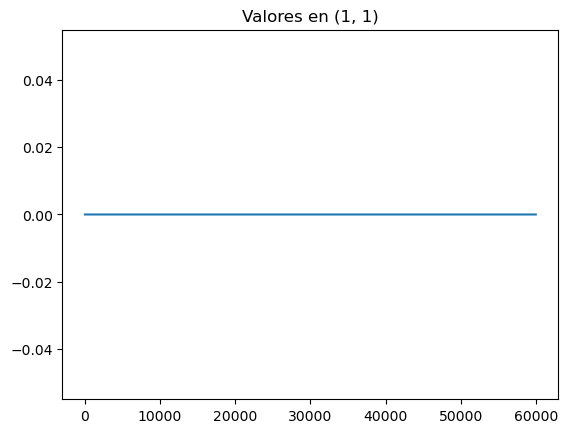

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_X(X, title, xscale, yscale):
    plt.title(title)
    plt.plot(X)
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.show()

# Example values for fila and columna
fila = 1
columna = 1

features_fila_col = X_train[:, fila, columna]
print(len(np.unique(features_fila_col)))

title = "Valores en (" + str(fila) + ", " + str(columna) + ")"
xscale = "linear"  # Define the xscale
yscale = "linear"  # Define the yscale

plot_X(features_fila_col, title, xscale, yscale)


Tarea 1A: DecisionStump y ADABoost Binario sin mejoras

In [181]:
import numpy as np

def balance_training_dataset(digit, X_train, y_train):
    # Find indices of the target digit and calculate how many there are
    target_indices = np.where(y_train == digit)[0]
    num_target_samples = len(target_indices)
    print(f"Total elements for target digit {digit}: {num_target_samples}")

    # Determine how many samples each non-target digit should have
    num_samples_per_other_digit = num_target_samples // 9
    print(f"Each non-target digit will have {num_samples_per_other_digit} samples.")

    # Initialize lists to collect balanced dataset samples
    X_train_balanced = []
    y_train_balanced = []

    # Add target digit samples to the balanced dataset
    X_train_balanced.extend(X_train[target_indices])
    y_train_balanced.extend(y_train[target_indices])

    # Collect samples for each non-target digit class to balance the dataset
    for i in range(10):  # There are 10 digit classes (0-9)
        if i == digit:
            continue  # Skip the target digit
        indices = np.where(y_train == i)[0]
        if len(indices) >= num_samples_per_other_digit:
            balanced_indices = np.random.choice(indices, num_samples_per_other_digit, replace=False)
        else:
            balanced_indices = np.random.choice(indices, num_samples_per_other_digit, replace=True)
        X_train_balanced.extend(X_train[balanced_indices])
        y_train_balanced.extend([i] * num_samples_per_other_digit)
        print(f"Collected {len(balanced_indices)} samples for digit {i}.")

    # Convert lists to numpy arrays for training
    X_train_balanced = np.array(X_train_balanced)
    y_train_balanced = np.array(y_train_balanced)

    # Convert labels to binary (1 for the specified digit, -1 for all others)
    y_train_binary_balanced = np.where(y_train_balanced == digit, 1, -1)

    # Shuffle the balanced training set
    shuffle_indices = np.random.permutation(len(X_train_balanced))
    X_train_balanced = X_train_balanced[shuffle_indices]
    y_train_binary_balanced = y_train_binary_balanced[shuffle_indices]

    return X_train_balanced, y_train_binary_balanced

In [188]:
import numpy as np  # la libreería numpy sirve para trabajar con matrices
from tensorflow.keras.datasets import mnist # importamos el dataset MNIST

class DecisionStump: # Creamos la clase DecisionStump
    def __init__(self, img_shape): # Inicializamos la clase
        self.feature_index = (np.random.randint(0, img_shape[0]), np.random.randint(0, img_shape[1])) # Elegimos un índice de característica aleatorio en 2D
        self.threshold = None # Inicializamos el umbral
        self.polarity = 1 # Inicializamos la polaridad
        self.img_shape = img_shape # Inicializamos la forma de la imagen
        self.alpha = None # Inicializamos el alpha

    def predict(self, X): # Creamos la función predict
        n_samples = X.shape[0] # Obtenemos el número de muestras
        X_column = X[:, self.feature_index[0], self.feature_index[1]] # Obtenemos la columna de la característica
        predictions = np.ones(n_samples) # Inicializamos las predicciones
        if self.polarity == 1: # Si la polaridad es 1
            predictions[X_column < self.threshold] = -1 # Si la columna de la característica es menor que el umbral, la predicción es -1
        else: # Si la polaridad no es 1
            predictions[X_column >= self.threshold] = -1 # Si la columna de la característica es mayor o igual que el umbral, la predicción es -1
        return predictions # Devolvemos las predicciones

class AdaBoost: # Creamos la clase AdaBoost
    def __init__(self, T=5, A=20): # Inicializamos la clase
        self.T = T # Inicializamos el número de clasificadores débiles
        self.A = A # Inicializamos el número de píxeles máximos a probar por clasificador débil
        self.clfs = [] # Inicializamos los clasificadores débiles

    def fit(self, X, Y, verbose=False): # Creamos la función fit
        n_samples, img_rows, img_cols = X.shape # Obtenemos el número de muestras y el tamaño de la imagen
        w = np.full(n_samples, (1 / n_samples)) # Inicializamos los pesos

        for t in range(self.T): # Para cada iteración
            min_error = float('inf') # Inicializamos el error mínimo
            best_clf = None # Inicializamos el mejor clasificador débil

            for _ in range(self.A): # Para cada clasificador débil
                clf = DecisionStump((img_rows, img_cols)) # Creamos un clasificador débil
                clf.threshold = np.random.uniform(min(X[:, clf.feature_index[0], clf.feature_index[1]]), max(X[:, clf.feature_index[0], clf.feature_index[1]])) # Elegimos un umbral aleatorio
                clf.polarity = 1 # Elegimos una polaridad
                predictions = clf.predict(X) # Realizamos las predicciones
                error = np.sum(w[Y != predictions]) # Calculamos el error
                if error > 0.5: # Si el error es mayor que 0.5
                    error = 1 - error # El error es 1 menos el error
                    clf.polarity = -1 # La polaridad es -1

                if error < min_error: # Si el error es menor que el error mínimo
                    min_error = error # El error mínimo es el error
                    best_clf = clf # El mejor clasificador débil es el clasificador débil

            EPS = 1e-10 # Definimos un valor muy pequeño
            best_clf.alpha = 0.5 * np.log((1.0 - min_error + EPS) / (min_error + EPS)) # Calculamos el alpha
            predictions = best_clf.predict(X) # Realizamos las predicciones
            w *= np.exp(-best_clf.alpha * Y * predictions) # Actualizamos los pesos
            w /= np.sum(w)  # Normalizamos los pesos
            self.clfs.append(best_clf) # Añadimos el mejor clasificador débil

            if verbose: # Si verbose es True
                print(f'Classifier {t + 1}/{self.T}: error = {min_error}, alpha = {best_clf.alpha}') # Mostramos el error y el alpha

    def predict(self, X): # Creamos la función predict
        clf_preds = np.zeros(X.shape[0]) # Inicializamos las predicciones
        for clf in self.clfs: # Para cada clasificador débil
            predictions = clf.predict(X) # Realizamos las predicciones
            clf_preds += clf.alpha * predictions # Actualizamos las predicciones
        return clf_preds # Devolvemos las predicciones

def run_adaboost_on_mnist(digit, T=5, A=20, verboseParam=False): # Creamos la función run_adaboost_on_mnist
    print(f"Running AdaBoost for digit: {digit}") # Mostramos el dígito

    (X_train, y_train), (X_test, y_test) = mnist.load_data() # Cargamos los datos

    X_train_balanced, Y_train_binary_balanced = balance_training_dataset(digit, X_train, y_train) # Convertimos las etiquetas a binarias
    
    y_test_binary = np.where(y_test == digit, 1, -1) # Convertimos las etiquetas a binarias

    adaboost = AdaBoost(T=T, A=A) # Creamos el clasificador AdaBoost
    adaboost.fit(X_train_balanced, Y_train_binary_balanced, verboseParam) # Ajustamos el clasificador AdaBoost
    y_pred = adaboost.predict(X_test) # Realizamos las predicciones
    accuracy = np.sum(y_test_binary == np.sign(y_pred)) / len(y_test_binary) # Calculamos la precisión
    print(f"Accuracy for digit {digit}: {accuracy}") # Mostramos la precisión

    return accuracy # Devolvemos la precisión

def run_adaboost_for_all_digits(T=5, A=20, verboseParam=False): # Creamos la función run_adaboost_for_all_digits
    accuracies = {} # Inicializamos las precisiones
    for digit in range(10): # Para cada dígito
        accuracy = run_adaboost_on_mnist(digit, T, A, verboseParam) # Ejecutamos AdaBoost
        accuracies[digit] = accuracy # Guardamos la precisión
    return accuracies # Devolvemos las precisiones

In [190]:
accuracy = run_adaboost_on_mnist(digit=3, T=50, A=20, verboseParam=True)  # Ejecutamos AdaBoost

Running AdaBoost for digit: 3
Total elements for target digit 3: 6131
Each non-target digit will have 681 samples.
Collected 681 samples for digit 0.
Collected 681 samples for digit 1.
Collected 681 samples for digit 2.
Collected 681 samples for digit 4.
Collected 681 samples for digit 5.
Collected 681 samples for digit 6.
Collected 681 samples for digit 7.
Collected 681 samples for digit 8.
Collected 681 samples for digit 9.
Classifier 1/50: error = 0.4079119086460033, alpha = 0.18630209289483984
Classifier 2/50: error = 0.41637255962372965, alpha = 0.16884119956704424
Classifier 3/50: error = 0.32631601000240573, alpha = 0.3624474377777707
Classifier 4/50: error = 0.3395251458907941, alpha = 0.3327055202103747
Classifier 5/50: error = 0.2625715923845365, alpha = 0.51632261554835
Classifier 6/50: error = 0.4255071393813248, alpha = 0.150102971675958
Classifier 7/50: error = 0.31738618759556725, alpha = 0.3829049906432699
Classifier 8/50: error = 0.3542920403873021, alpha = 0.300112890

In [192]:
all_accuracies = run_adaboost_for_all_digits(T=50, A=50, verboseParam=True) # Ejecutamos AdaBoost para todos los dígitos
print("Accuracies for all digits:", all_accuracies) # Imprimimos las precisiones

Running AdaBoost for digit: 0
Total elements for target digit 0: 5923
Each non-target digit will have 658 samples.
Collected 658 samples for digit 1.
Collected 658 samples for digit 2.
Collected 658 samples for digit 3.
Collected 658 samples for digit 4.
Collected 658 samples for digit 5.
Collected 658 samples for digit 6.
Collected 658 samples for digit 7.
Collected 658 samples for digit 8.
Collected 658 samples for digit 9.
Classifier 1/50: error = 0.23410721823554248, alpha = 0.5926314900275834
Classifier 2/50: error = 0.1496936437055697, alpha = 0.86850293643049
Classifier 3/50: error = 0.3038599010556179, alpha = 0.4144920940443126
Classifier 4/50: error = 0.3320986777698548, alpha = 0.34935414715398183
Classifier 5/50: error = 0.2825268254289056, alpha = 0.46598102800705965
Classifier 6/50: error = 0.29736481471336773, alpha = 0.4299390498422789
Classifier 7/50: error = 0.294875641007898, alpha = 0.43591023561891123
Classifier 8/50: error = 0.3437150359413196, alpha = 0.323391080

Tarea 1B: Experimentación con los parámetros T y A del método AdaboostBinario.predict

Tareas 1C y 1D: ADABoost Binario con mejoras y ADABoost Multiclase

Multiclase con ADABoosti Binario sin Mejoras

In [185]:
import numpy as np  # la libreería numpy sirve para trabajar con matrices
from tensorflow.keras.datasets import mnist # importamos el dataset MNIST

class DecisionStump: # Creamos la clase DecisionStump
    def __init__(self, img_shape): # Inicializamos la clase
        self.feature_index = (np.random.randint(0, img_shape[0]), np.random.randint(0, img_shape[1])) # Elegimos un índice de característica aleatorio en 2D
        self.threshold = None # Inicializamos el umbral
        self.polarity = 1 # Inicializamos la polaridad
        self.img_shape = img_shape # Inicializamos la forma de la imagen
        self.alpha = None # Inicializamos el alpha

    def predict(self, X): # Creamos la función predict
        n_samples = X.shape[0] # Obtenemos el número de muestras
        X_column = X[:, self.feature_index[0], self.feature_index[1]] # Obtenemos la columna de la característica
        predictions = np.ones(n_samples) # Inicializamos las predicciones
        if self.polarity == 1: # Si la polaridad es 1
            predictions[X_column < self.threshold] = -1 # Si la columna de la característica es menor que el umbral, la predicción es -1
        else: # Si la polaridad no es 1
            predictions[X_column >= self.threshold] = -1 # Si la columna de la característica es mayor o igual que el umbral, la predicción es -1
        return predictions # Devolvemos las predicciones

class AdaBoost: # Creamos la clase AdaBoost
    def __init__(self, T=5, A=20): # Inicializamos la clase
        self.T = T # Inicializamos el número de clasificadores débiles
        self.A = A # Inicializamos el número de píxeles máximos a probar por clasificador débil
        self.clfs = [] # Inicializamos los clasificadores débiles

    def fit(self, X, Y, verbose=False): # Creamos la función fit
        n_samples, img_rows, img_cols = X.shape # Obtenemos el número de muestras y el tamaño de la imagen
        w = np.full(n_samples, (1 / n_samples)) # Inicializamos los pesos

        for t in range(self.T): # Para cada iteración
            min_error = float('inf') # Inicializamos el error mínimo
            best_clf = None # Inicializamos el mejor clasificador débil

            for _ in range(self.A): # Para cada clasificador débil
                clf = DecisionStump((img_rows, img_cols)) # Creamos un clasificador débil
                clf.threshold = np.random.uniform(min(X[:, clf.feature_index[0], clf.feature_index[1]]), max(X[:, clf.feature_index[0], clf.feature_index[1]])) # Elegimos un umbral aleatorio
                clf.polarity = 1 # Elegimos una polaridad
                predictions = clf.predict(X) # Realizamos las predicciones
                error = np.sum(w[Y != predictions]) # Calculamos el error
                if error > 0.5: # Si el error es mayor que 0.5
                    error = 1 - error # El error es 1 menos el error
                    clf.polarity = -1 # La polaridad es -1

                if error < min_error: # Si el error es menor que el error mínimo
                    min_error = error # El error mínimo es el error
                    best_clf = clf # El mejor clasificador débil es el clasificador débil

            EPS = 1e-10 # Definimos un valor muy pequeño
            best_clf.alpha = 0.5 * np.log((1.0 - min_error + EPS) / (min_error + EPS)) # Calculamos el alpha
            predictions = best_clf.predict(X) # Realizamos las predicciones
            w *= np.exp(-best_clf.alpha * Y * predictions) # Actualizamos los pesos
            w /= np.sum(w)  # Normalizamos los pesos
            self.clfs.append(best_clf) # Añadimos el mejor clasificador débil

            if verbose: # Si verbose es True
                print(f'Classifier {t + 1}/{self.T}: error = {min_error}, alpha = {best_clf.alpha}') # Mostramos el error y el alpha

    def predict(self, X): # Creamos la función predict
        clf_preds = np.zeros(X.shape[0]) # Inicializamos las predicciones
        for clf in self.clfs: # Para cada clasificador débil
            predictions = clf.predict(X) # Realizamos las predicciones
            clf_preds += clf.alpha * predictions # Actualizamos las predicciones
        return clf_preds # Devolvemos las predicciones

def run_adaboost_on_mnist(digit, T=5, A=20, verboseParam=False): # Creamos la función run_adaboost_on_mnist
    print(f"Running AdaBoost for digit: {digit}") # Mostramos el dígito

    (X_train, y_train), (X_test, y_test) = mnist.load_data() # Cargamos los datos

    X_train_balanced, Y_train_binary_balanced = balance_training_dataset(digit, X_train, y_train) # Convertimos las etiquetas a binarias
    
    y_test_binary = np.where(y_test == digit, 1, -1) # Convertimos las etiquetas a binarias

    adaboost = AdaBoost(T=T, A=A) # Creamos el clasificador AdaBoost
    adaboost.fit(X_train_balanced, Y_train_binary_balanced, verboseParam) # Ajustamos el clasificador AdaBoost
    y_pred = adaboost.predict(X_test) # Realizamos las predicciones
    accuracy = np.sum(y_test_binary == np.sign(y_pred)) / len(y_test_binary) # Calculamos la precisión
    print(f"Accuracy for digit {digit}: {accuracy}") # Mostramos la precisión

    return accuracy # Devolvemos la precisión

def run_adaboost_for_all_digits(T=5, A=20, verboseParam=False): # Creamos la función run_adaboost_for_all_digits
    accuracies = {} # Inicializamos las precisiones
    for digit in range(10): # Para cada dígito
        accuracy = run_adaboost_on_mnist(digit, T, A, verboseParam) # Ejecutamos AdaBoost
        accuracies[digit] = accuracy # Guardamos la precisión
    return accuracies # Devolvemos las precisiones

In [187]:
accuracy = run_adaboost_on_mnist(digit=3, T=50, A=20, verboseParam=True)  # Ejecutamos AdaBoost

Running AdaBoost for digit: 3
Total elements for target digit 3: 6131
Each non-target digit will have 681 samples.
Collected 681 samples for digit 0.
Collected 681 samples for digit 1.
Collected 681 samples for digit 2.
Collected 681 samples for digit 4.
Collected 681 samples for digit 5.
Collected 681 samples for digit 6.
Collected 681 samples for digit 7.
Collected 681 samples for digit 8.
Collected 681 samples for digit 9.
Classifier 1/50: error = 0.3950244698205547, alpha = 0.21312014962273784
Classifier 2/50: error = 0.3119191083171587, alpha = 0.39558125999382115
Classifier 3/50: error = 0.31984957387585244, alpha = 0.37723159239788917
Classifier 4/50: error = 0.3355120857365491, alpha = 0.3416793556513819
Classifier 5/50: error = 0.40581352393301107, alpha = 0.19064972467869068
Classifier 6/50: error = 0.37500372545637967, alpha = 0.2554048642051783
Classifier 7/50: error = 0.3825585205933858, alpha = 0.23935132857028116
Classifier 8/50: error = 0.3725471385041592, alpha = 0.260

In [193]:
all_accuracies = run_adaboost_for_all_digits(T=50, A=50, verboseParam=True) # Ejecutamos AdaBoost para todos los dígitos
print("Accuracies for all digits:", all_accuracies) # Imprimimos las precisiones

Running AdaBoost for digit: 0
Total elements for target digit 0: 5923
Each non-target digit will have 658 samples.
Collected 658 samples for digit 1.
Collected 658 samples for digit 2.
Collected 658 samples for digit 3.
Collected 658 samples for digit 4.
Collected 658 samples for digit 5.
Collected 658 samples for digit 6.
Collected 658 samples for digit 7.
Collected 658 samples for digit 8.
Collected 658 samples for digit 9.
Classifier 1/50: error = 0.24491346559729854, alpha = 0.5629637054988017
Classifier 2/50: error = 0.24448462194092319, alpha = 0.5641238625246932
Classifier 3/50: error = 0.24412186669791447, alpha = 0.565106304642309
Classifier 4/50: error = 0.2967349614341819, alpha = 0.43144723834067106
Classifier 5/50: error = 0.2673657983871189, alpha = 0.5040143910448964
Classifier 6/50: error = 0.2908849036473995, alpha = 0.44554509025745376
Classifier 7/50: error = 0.3588952326140195, alpha = 0.2900811861819371
Classifier 8/50: error = 0.3222999207350743, alpha = 0.3716111

In [134]:
class AdaBoostMulticlass: # Creamos la clase AdaBoostMulticlass
    def __init__(self, T=5, A=20): # Inicializamos la clase
        self.T = T # Inicializamos el número de clasificadores débiles
        self.A = A # Inicializamos el número de píxeles máximos a probar por clasificador débil
        self.models = [] # Inicializamos los modelos

    def fit(self, X, y, verbose=False): # Creamos la función fit
        for digit in range(10): # Para cada dígito
            y_binary = np.where(y == digit, 1, -1) # Convertimos las etiquetas a binarias
            model = AdaBoost(T=self.T, A=self.A) # Creamos el clasificador AdaBoost
            model.fit(X, y_binary, verbose) # Ajustamos el clasificador AdaBoost
            self.models.append(model) # Añadimos el clasificador AdaBoost

    def predict(self, X): # Creamos la función predict
        model_preds = np.array([model.predict(X) for model in self.models]) # Realizamos las predicciones
        return np.argmax(model_preds, axis=0) # Devolvemos el índice del valor máximo

def run_adaboost_multiclass_on_mnist(T=5, A=20, verboseParam=False): # Creamos la función run_adaboost_multiclass_on_mnist
    (X_train, y_train), (X_test, y_test) = mnist.load_data() # Cargamos los datos

    adaboost_multiclass = AdaBoostMulticlass(T=T, A=A) # Creamos el clasificador AdaBoostMulticlass
    adaboost_multiclass.fit(X_train, y_train, verboseParam) # Ajustamos el clasificador AdaBoostMulticlass
    y_pred = adaboost_multiclass.predict(X_test) # Realizamos las predicciones
    accuracy = np.sum(y_test == y_pred) / len(y_test) # Calculamos la precisión
    print(f"Multiclass Accuracy: {accuracy}") # Mostramos la precisión
    return accuracy # Devolvemos la precisión

accuracy = run_adaboost_multiclass_on_mnist(T=50, A=20, verboseParam=False) # Ejecutamos AdaBoostMulticlass

Multiclass Accuracy: 0.828


Multiclase con ADABoosti Binario con Mejoras (Version 1: Solo añadido el parámetro n_componentes)

In [163]:
import numpy as np  # la libreería numpy sirve para trabajar con matrices
from tensorflow.keras.datasets import mnist # importamos el dataset MNIST
from sklearn.decomposition import PCA # importamos Principal Component Analysis

class DecisionStump: # Creamos la clase DecisionStump
    def __init__(self, n_features): # Inicializamos la clase
        self.feature_index = np.random.randint(0, n_features) # Elegimos un índice de característica aleatorio
        self.threshold = None # Inicializamos el umbral
        self.polarity = 1 # Inicializamos la polaridad
        self.n_features = n_features # Inicializamos el número de características
        self.alpha = None # Inicializamos el alpha
        
    def predict(self, X): # Creamos la función predict
        n_samples = X.shape[0] # Obtenemos el número de muestras
        X_column = X[:, self.feature_index] # Obtenemos la columna de la característica
        predictions = np.ones(n_samples) # Inicializamos las predicciones
        if self.polarity == 1: # Si la polaridad es 1
            predictions[X_column < self.threshold] = -1 # Si la columna de la característica es menor que el umbral, la predicción es -1
        else: # Si la polaridad no es 1
            predictions[X_column >= self.threshold] = -1 # Si la columna de la característica es mayor o igual que el umbral, la predicción es -1
        return predictions # Devolvemos las predicciones

class AdaBoost: # Creamos la clase AdaBoost
    def __init__(self, T=5, A=20): # Inicializamos la clase
        self.T = T # Inicializamos el número de clasificadores débiles
        self.A = A # Inicializamos el número de píxeles máximos a probar por clasificador débil
        self.clfs = [] # Inicializamos los clasificadores débiles

    def fit(self, X, Y, verbose=False): # Creamos la función fit
        n_samples, n_features = X.shape # Obtenemos el número de muestras y el número de características
        w = np.full(n_samples, (1 / n_samples)) # Inicializamos los pesos

        for t in range(self.T): # Para cada iteración
            min_error = float('inf') # Inicializamos el error mínimo
            best_clf = None # Inicializamos el mejor clasificador débil

            for _ in range(self.A): # Para cada clasificador débil
                clf = DecisionStump(n_features) # Creamos un clasificador débil
                clf.threshold = np.random.uniform(min(X[:, clf.feature_index]), max(X[:, clf.feature_index])) # Elegimos un umbral aleatorio
                clf.polarity = 1 # Elegimos una polaridad
                predictions = clf.predict(X) # Realizamos las predicciones
                error = np.sum(w[Y != predictions]) # Calculamos el error
                if error > 0.5: # Si el error es mayor que 0.5
                    error = 1 - error # El error es 1 menos el error
                    clf.polarity = -1 # La polaridad es -1

                if error < min_error: # Si el error es menor que el error mínimo
                    min_error = error # El error mínimo es el error
                    best_clf = clf # El mejor clasificador débil es el clasificador débil

            EPS = 1e-10 # Definimos un valor muy pequeño
            best_clf.alpha = 0.5 * np.log((1.0 - min_error + EPS) / (min_error + EPS)) # Calculamos el alpha
            predictions = best_clf.predict(X) # Realizamos las predicciones
            w *= np.exp(-best_clf.alpha * Y * predictions) # Actualizamos los pesos
            w /= np.sum(w)  # Normalizamos los pesos
            self.clfs.append(best_clf) # Añadimos el mejor clasificador débil

            if verbose: # Si verbose es True
                print(f'Classifier {t + 1}/{self.T}: error = {min_error}, alpha = {best_clf.alpha}') # Mostramos el error y el alpha

    def predict(self, X): # Creamos la función predict
        clf_preds = np.zeros(X.shape[0]) # Inicializamos las predicciones
        for clf in self.clfs: # Para cada clasificador débil
            predictions = clf.predict(X) # Realizamos las predicciones
            clf_preds += clf.alpha * predictions # Actualizamos las predicciones
        return clf_preds # Devolvemos las predicciones

def apply_pca(X_train, X_test, n_components=50): # Creamos la función apply_pca
    pca = PCA(n_components=n_components) # Creamos el objeto PCA
    X_train_reduced = pca.fit_transform(X_train) # Aplicamos PCA a los datos de entrenamiento
    X_test_reduced = pca.transform(X_test) # Aplicamos PCA a los datos de prueba
    return X_train_reduced, X_test_reduced # Devolvemos los datos reducidos


def run_adaboost_on_mnist(digit, T=5, A=20, verboseParam=False):
    print(f"Running AdaBoost for digit: {digit}")

    # Load MNIST data
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    # Balance the training dataset for the specified digit
    X_train_balanced, Y_train_binary_balanced = balance_training_dataset(digit, X_train, y_train)

    # Flatten the images
    X_train_balanced = X_train_balanced.reshape(X_train_balanced.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

    # Create the AdaBoost classifier (assuming AdaBoost class is properly defined and imported)
    adaboost = AdaBoost(T=T, A=A)
    adaboost.fit(X_train_balanced, Y_train_binary_balanced, verboseParam)  # Train the model
    y_pred = adaboost.predict(X_test)  # Predict on the test set

    # Convert test labels to binary
    y_test_binary = np.where(y_test == digit, 1, -1)

    # Calculate accuracy using the correct labels
    accuracy = np.sum(y_test_binary == np.sign(y_pred)) / len(y_test_binary)
    print(f"Accuracy for digit {digit}: {accuracy}")

    return accuracy


def run_adaboost_for_all_digits(T=5, A=20, verboseParam=False): # Creamos la función run_adaboost_for_all_digits
    accuracies = {} # Inicializamos las precisiones
    for digit in range(10): # Para cada dígito
        accuracy = run_adaboost_on_mnist(digit, T, A, verboseParam) # Ejecutamos AdaBoost
        accuracies[digit] = accuracy # Guardamos la precisión
    return accuracies # Devolvemos las precisiones

In [179]:
accuracy = run_adaboost_on_mnist(digit=4, T=50, A=50, verboseParam=True)  # Ejecutamos AdaBoost

Running AdaBoost for digit: 4
Total elements for target digit 4: 5842
Each non-target digit will have 649 samples.
Collected 649 samples for digit 0.
Collected 649 samples for digit 1.
Collected 649 samples for digit 2.
Collected 649 samples for digit 3.
Collected 649 samples for digit 5.
Collected 649 samples for digit 6.
Collected 649 samples for digit 7.
Collected 649 samples for digit 8.
Collected 649 samples for digit 9.
Classifier 1/50: error = 0.3238038175126252, alpha = 0.36817270683057024
Classifier 2/50: error = 0.3303056143923935, alpha = 0.3534015685867737
Classifier 3/50: error = 0.33487353706673195, alpha = 0.3431121164959386
Classifier 4/50: error = 0.381654878632417, alpha = 0.24126500456687197
Classifier 5/50: error = 0.3554041397618325, alpha = 0.29768399159368425
Classifier 6/50: error = 0.3388560748273497, alpha = 0.3341980476720072
Classifier 7/50: error = 0.386269231956563, alpha = 0.23151086245633945
Classifier 8/50: error = 0.37330672312370117, alpha = 0.2590284

In [175]:
all_accuracies = run_adaboost_for_all_digits(T=50, A=20, verboseParam=True) # Ejecutamos AdaBoost para todos los dígitos
print("Accuracies for all digits:", all_accuracies) # Imprimimos las precisiones

Running AdaBoost for digit: 0
Total elements for target digit 0: 5923
Each non-target digit will have 658 samples.
Collected 658 samples for digit 1.
Collected 658 samples for digit 2.
Collected 658 samples for digit 3.
Collected 658 samples for digit 4.
Collected 658 samples for digit 5.
Collected 658 samples for digit 6.
Collected 658 samples for digit 7.
Collected 658 samples for digit 8.
Collected 658 samples for digit 9.
Classifier 1/50: error = 0.3511186154495568, alpha = 0.3070629156255924
Classifier 2/50: error = 0.20106241385725143, alpha = 0.6898337254080968
Classifier 3/50: error = 0.20274171865047586, alpha = 0.6846229229138829
Classifier 4/50: error = 0.25230076133422674, alpha = 0.5431894681450896
Classifier 5/50: error = 0.35104183271278433, alpha = 0.3072314297145393
Classifier 6/50: error = 0.38280134339680305, alpha = 0.2388373874099552
Classifier 7/50: error = 0.24998877302048728, alpha = 0.5493360832609213
Classifier 8/50: error = 0.363080954464222, alpha = 0.281008

In [173]:
class AdaBoostMulticlass: # Creamos la clase AdaBoostMulticlass
    def __init__(self, T=5, A=20): # Inicializamos la clase
        self.T = T # Inicializamos el número de clasificadores débiles
        self.A = A # Inicializamos el número de píxeles máximos a probar por clasificador débil
        self.models = [] # Inicializamos los modelos

    def fit(self, X, y, verbose=False): # Creamos la función fit
        for digit in range(10): # Para cada dígito
            y_binary = np.where(y == digit, 1, -1) # Convertimos las etiquetas a binarias
            model = AdaBoost(T=self.T, A=self.A) # Creamos el clasificador AdaBoost
            model.fit(X, y_binary, verbose) # Ajustamos el clasificador AdaBoost
            self.models.append(model) # Añadimos el clasificador AdaBoost

    def predict(self, X): # Creamos la función predict
        model_preds = np.array([model.predict(X) for model in self.models]) # Realizamos las predicciones
        return np.argmax(model_preds, axis=0) # Devolvemos el índice del valor máximo

def run_adaboost_multiclass_on_mnist(T=5, A=20, verboseParam=False, n_components=50): # Creamos la función run_adaboost_multiclass_on_mnist
    (X_train, y_train), (X_test, y_test) = mnist.load_data() # Cargamos los datos
    X_train = X_train.reshape(X_train.shape[0], -1) # Redimensionamos los datos
    X_test = X_test.reshape(X_test.shape[0], -1) # Redimensionamos los datos

    # Apply PCA
    X_train_reduced, X_test_reduced = apply_pca(X_train, X_test, n_components=n_components)

    adaboost_multiclass = AdaBoostMulticlass(T=T, A=A) # Creamos el clasificador AdaBoostMulticlass
    adaboost_multiclass.fit(X_train_reduced, y_train, verboseParam) # Ajustamos el clasificador AdaBoostMulticlass
    y_pred = adaboost_multiclass.predict(X_test_reduced) # Realizamos las predicciones
    accuracy = np.sum(y_test == y_pred) / len(y_test) # Calculamos la precisión
    print(f"Multiclass Accuracy: {accuracy}") # Mostramos la precisión
    return accuracy # Devolvemos la precisión


accuracy = run_adaboost_multiclass_on_mnist(T=50, A=20, verboseParam=True) # Ejecutamos AdaBoostMulticlass

Classifier 1/50: error = 0.09866666666666671, alpha = 1.1060639909681136
Classifier 2/50: error = 0.4502146468560444, alpha = 0.09990173647425882
Classifier 3/50: error = 0.41605589022012435, alpha = 0.1694928365100204
Classifier 4/50: error = 0.4256140034960232, alpha = 0.14988439879660334
Classifier 5/50: error = 0.4679091233703502, alpha = 0.06427009961528354
Classifier 6/50: error = 0.46177830605167136, alpha = 0.07659281345335602
Classifier 7/50: error = 0.12352752043735227, alpha = 0.9797206681384945
Classifier 8/50: error = 0.4005681545376596, alpha = 0.20154917831513952
Classifier 9/50: error = 0.44751133652885994, alpha = 0.10536552205762431
Classifier 10/50: error = 0.282074728259039, alpha = 0.4670967277007162
Classifier 11/50: error = 0.31405173560506616, alpha = 0.3906222364828058
Classifier 12/50: error = 0.40777727175438827, alpha = 0.1865808357065479
Classifier 13/50: error = 0.44276836203847625, alpha = 0.11496713600213491
Classifier 14/50: error = 0.4233947781670756, 

Multiclase con ADABoosti Binario con Mejoras (Version 1: Añadidos los parámetros n_componentes y k)

In [138]:
import numpy as np  # la libreería numpy sirve para trabajar con matrices
from tensorflow.keras.datasets import mnist # importamos el dataset MNIST
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif

class DecisionStump: # Creamos la clase DecisionStump
    def __init__(self, n_features): # Inicializamos la clase
        self.feature_index = np.random.randint(0, n_features) # Elegimos un índice de característica aleatorio
        self.threshold = None # Inicializamos el umbral
        self.polarity = 1 # Inicializamos la polaridad
        self.n_features = n_features # Inicializamos el número de características
        self.alpha = None # Inicializamos el alpha
        
    def predict(self, X): # Creamos la función predict
        n_samples = X.shape[0] # Obtenemos el número de muestras
        X_column = X[:, self.feature_index] # Obtenemos la columna de la característica
        predictions = np.ones(n_samples) # Inicializamos las predicciones
        if self.polarity == 1: # Si la polaridad es 1
            predictions[X_column < self.threshold] = -1 # Si la columna de la característica es menor que el umbral, la predicción es -1
        else: # Si la polaridad no es 1
            predictions[X_column >= self.threshold] = -1 # Si la columna de la característica es mayor o igual que el umbral, la predicción es -1
        return predictions # Devolvemos las predicciones

class AdaBoost: # Creamos la clase AdaBoost
    def __init__(self, T=5, A=20): # Inicializamos la clase
        self.T = T # Inicializamos el número de clasificadores débiles
        self.A = A # Inicializamos el número de píxeles máximos a probar por clasificador débil
        self.clfs = [] # Inicializamos los clasificadores débiles

    def fit(self, X, Y, verbose=False): # Creamos la función fit
        n_samples, n_features = X.shape # Obtenemos el número de muestras y el número de características
        w = np.full(n_samples, (1 / n_samples)) # Inicializamos los pesos

        for t in range(self.T): # Para cada iteración
            min_error = float('inf') # Inicializamos el error mínimo
            best_clf = None # Inicializamos el mejor clasificador débil

            for _ in range(self.A): # Para cada clasificador débil
                clf = DecisionStump(n_features) # Creamos un clasificador débil
                clf.threshold = np.random.uniform(min(X[:, clf.feature_index]), max(X[:, clf.feature_index])) # Elegimos un umbral aleatorio
                clf.polarity = 1 # Elegimos una polaridad
                predictions = clf.predict(X) # Realizamos las predicciones
                error = np.sum(w[Y != predictions]) # Calculamos el error
                if error > 0.5: # Si el error es mayor que 0.5
                    error = 1 - error # El error es 1 menos el error
                    clf.polarity = -1 # La polaridad es -1

                if error < min_error: # Si el error es menor que el error mínimo
                    min_error = error # El error mínimo es el error
                    best_clf = clf # El mejor clasificador débil es el clasificador débil

            EPS = 1e-10 # Definimos un valor muy pequeño
            best_clf.alpha = 0.5 * np.log((1.0 - min_error + EPS) / (min_error + EPS)) # Calculamos el alpha
            predictions = best_clf.predict(X) # Realizamos las predicciones
            w *= np.exp(-best_clf.alpha * Y * predictions) # Actualizamos los pesos
            w /= np.sum(w)  # Normalizamos los pesos
            self.clfs.append(best_clf) # Añadimos el mejor clasificador débil

            if verbose: # Si verbose es True
                print(f'Classifier {t + 1}/{self.T}: error = {min_error}, alpha = {best_clf.alpha}') # Mostramos el error y el alpha

    def predict(self, X): # Creamos la función predict
        clf_preds = np.zeros(X.shape[0]) # Inicializamos las predicciones
        for clf in self.clfs: # Para cada clasificador débil
            predictions = clf.predict(X) # Realizamos las predicciones
            clf_preds += clf.alpha * predictions # Actualizamos las predicciones
        return clf_preds # Devolvemos las predicciones

def apply_pca(X_train, X_test, n_components=50): # Creamos la función apply_pca
    pca = PCA(n_components=n_components) # Creamos el objeto PCA
    X_train_reduced = pca.fit_transform(X_train) # Aplicamos PCA a los datos de entrenamiento
    X_test_reduced = pca.transform(X_test) # Aplicamos PCA a los datos de prueba
    return X_train_reduced, X_test_reduced # Devolvemos los datos reducidos

def select_best_features(X_train, y_train, X_test, k=200): # Creamos la función select_best_features
    selector = SelectKBest(f_classif, k=k) # Creamos el objeto SelectKBest
    X_train_best = selector.fit_transform(X_train, y_train) # Seleccionamos las mejores características de los datos de entrenamiento
    X_test_best = selector.transform(X_test) # Seleccionamos las mejores características de los datos de prueba
    return X_train_best, X_test_best # Devolvemos los datos con las mejores características


def run_adaboost_on_mnist(digit, T=5, A=20, verboseParam=False, n_components=50, k=200): # Creamos la función run_adaboost_on_mnist
    print(f"Running AdaBoost for digit: {digit}") # Mostramos el dígito

    (X_train, y_train), (X_test, y_test) = mnist.load_data() # Cargamos los datos

    X_train = X_train.reshape(X_train.shape[0], -1) # Redimensionamos los datos para reducir la dimensión de las imagénes a 1D
    X_test = X_test.reshape(X_test.shape[0], -1) # Redimensionamos los datos para reducir la dimensión de las imagénes a 1D

    X_train_best, X_test_best = select_best_features(X_train, y_train, X_test, k=k) # Seleccionamos las mejores características


    X_train_reduced, X_test_reduced = apply_pca(X_train_best, X_test_best, n_components=n_components) # Aplicamos PCA a los datos

    y_train_binary = np.where(y_train == digit, 1, -1) # Convertimos las etiquetas a binarias
    y_test_binary = np.where(y_test == digit, 1, -1) # Convertimos las etiquetas a binarias

    adaboost = AdaBoost(T=T, A=A) # Creamos el clasificador AdaBoost
    adaboost.fit(X_train_reduced, y_train_binary, verboseParam) # Ajustamos el clasificador AdaBoost
    y_pred = adaboost.predict(X_test_reduced) # Realizamos las predicciones
    accuracy = np.sum(y_test_binary == np.sign(y_pred)) / len(y_test_binary) # Calculamos la precisión
    print(f"Accuracy for digit {digit}: {accuracy}") # Mostramos la precisión

    return accuracy # Devolvemos la precisión

def run_adaboost_for_all_digits(T=5, A=20, verboseParam=False): # Creamos la función run_adaboost_for_all_digits
    accuracies = {} # Inicializamos las precisiones
    for digit in range(10): # Para cada dígito
        accuracy = run_adaboost_on_mnist(digit, T, A, verboseParam) # Ejecutamos AdaBoost
        accuracies[digit] = accuracy # Guardamos la precisión
    return accuracies # Devolvemos las precisiones

In [88]:
accuracy = run_adaboost_on_mnist(digit=3, T=5, A=20, verboseParam=True)  # Ejecutamos AdaBoost

Running AdaBoost for digit: 3
Classifier 1/5: error = 0.09578333333333311, alpha = 1.1224901549858723
Classifier 2/5: error = 0.423811546699126, alpha = 0.15357294594849832
Classifier 3/5: error = 0.44594286075021583, alpha = 0.10853849596112296
Classifier 4/5: error = 0.43261482746443425, alpha = 0.13559530076075985
Classifier 5/5: error = 0.47357464282143635, alpha = 0.05290000448255655
Accuracy for digit 3: 0.9003


In [89]:
all_accuracies = run_adaboost_for_all_digits(T=5, A=20, verboseParam=True) # Ejecutamos AdaBoost para todos los dígitos
print("Accuracies for all digits:", all_accuracies) # Imprimimos las precisiones

Running AdaBoost for digit: 0
Classifier 1/5: error = 0.06493333333333336, alpha = 1.3336283620106117
Classifier 2/5: error = 0.40729086733956765, alpha = 0.18758809260424628
Classifier 3/5: error = 0.45367364809500965, alpha = 0.09291920425006518
Classifier 4/5: error = 0.36758716202838615, alpha = 0.2712909696472824
Classifier 5/5: error = 0.45306292554869954, alpha = 0.09415136693421174
Accuracy for digit 0: 0.934
Running AdaBoost for digit: 1
Classifier 1/5: error = 0.11243333333333305, alpha = 1.033061590861527
Classifier 2/5: error = 0.4453157110817808, alpha = 0.10980780466445449
Classifier 3/5: error = 0.1714455120615499, alpha = 0.7877085495093323
Classifier 4/5: error = 0.2813040656471276, alpha = 0.46900109941991674
Classifier 5/5: error = 0.4102413735063475, alpha = 0.18148382156901965
Accuracy for digit 1: 0.8865
Running AdaBoost for digit: 2
Classifier 1/5: error = 0.09931666666666639, alpha = 1.1024201675356724
Classifier 2/5: error = 0.40659765491248473, alpha = 0.18902

In [139]:
class AdaBoostMulticlass: # Creamos la clase AdaBoostMulticlass
    def __init__(self, T=5, A=20): # Inicializamos la clase
        self.T = T # Inicializamos el número de clasificadores débiles
        self.A = A# Inicializamos el número de píxeles máximos a probar por clasificador débil
        self.models = [] # Inicializamos los modelos

    def fit(self, X, y, verbose=False): # Creamos la función fit
        for digit in range(10): # Para cada dígito
            y_binary = np.where(y == digit, 1, -1) # Convertimos las etiquetas a binarias
            model = AdaBoost(T=self.T, A=self.A) # Creamos el clasificador AdaBoost
            model.fit(X, y_binary, verbose) # Ajustamos el clasificador AdaBoost
            self.models.append(model) # Añadimos el clasificador AdaBoost

    def predict(self, X): # Creamos la función predict
        model_preds = np.array([model.predict(X) for model in self.models]) # Realizamos las predicciones
        return np.argmax(model_preds, axis=0) # Devolvemos el índice del valor máximo

def run_adaboost_multiclass_on_mnist(T=5, A=20, verboseParam=False, n_components=50, k=200): # Creamos la función run_adaboost_multiclass_on_mnist
    (X_train, y_train), (X_test, y_test) = mnist.load_data() # Cargamos los datos
    X_train = X_train.reshape(X_train.shape[0], -1) # Redimensionamos los datos
    X_test = X_test.reshape(X_test.shape[0], -1) # Redimensionamos los datos

    X_train_best, X_test_best = select_best_features(X_train, y_train, X_test, k=k) # Seleccionamos las mejores características

    X_train_reduced, X_test_reduced = apply_pca(X_train_best, X_test_best, n_components=n_components) # Aplicamos PCA a los datos

    adaboost_multiclass = AdaBoostMulticlass(T=T, A=A) # Creamos el clasificador AdaBoostMulticlass
    adaboost_multiclass.fit(X_train_reduced, y_train, verboseParam) # Ajustamos el clasificador AdaBoostMulticlass
    y_pred = adaboost_multiclass.predict(X_test_reduced) # Realizamos las predicciones
    accuracy = np.sum(y_test == y_pred) / len(y_test) # Calculamos la precisión
    print(f"Multiclass Accuracy: {accuracy}") # Mostramos la precisión
    return accuracy # Devolvemos la precisión


accuracy = run_adaboost_multiclass_on_mnist(T=50, A=20, verboseParam=False) # Ejecutamos AdaBoostMulticlass

c:\Users\Crislt\anaconda3\envs\SIPrac2Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [  0   1   2   3   4   5   6   7   8   9  10  11  16  17  18  19  20  21
  22  23  24  25  26  27  28  29  30  31  52  53  54  55  56  57  82  83
  84  85 111 112 140 141 168 476 560 644 645 671 672 673 699 700 701 727
 728 729 730 754 755 756 757 758 759 780 781 782 783] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\Crislt\anaconda3\envs\SIPrac2Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Multiclass Accuracy: 0.8016


Tarea 1E: Implementación de una versión de AdaboostBinario.fit que pare automáticamente el entrenamiento 
cuando detecte sobreentrenamiento.

In [53]:
import numpy as np  # la libreería numpy sirve para trabajar con matrices
from tensorflow.keras.datasets import mnist # importamos el dataset MNIST
from sklearn.decomposition import PCA # importamos Principal Component Analysis

class DecisionStump: # Creamos la clase DecisionStump
    def __init__(self, n_features): # Inicializamos la clase
        self.feature_index = np.random.randint(0, n_features) # Elegimos un índice de característica aleatorio
        self.threshold = None # Inicializamos el umbral
        self.polarity = 1 # Inicializamos la polaridad
        self.n_features = n_features # Inicializamos el número de características
        self.alpha = None # Inicializamos el alpha
        
    def predict(self, X): # Creamos la función predict
        n_samples = X.shape[0] # Obtenemos el número de muestras
        X_column = X[:, self.feature_index] # Obtenemos la columna de la característica
        predictions = np.ones(n_samples) # Inicializamos las predicciones
        if self.polarity == 1: # Si la polaridad es 1
            predictions[X_column < self.threshold] = -1 # Si la columna de la característica es menor que el umbral, la predicción es -1
        else: # Si la polaridad no es 1
            predictions[X_column >= self.threshold] = -1 # Si la columna de la característica es mayor o igual que el umbral, la predicción es -1
        return predictions # Devolvemos las predicciones

class AdaBoost: # Creamos la clase AdaBoost
    def __init__(self, T=5, A=20): # Inicializamos la clase
        self.T = T # Inicializamos el número de clasificadores débiles
        self.A = A # Inicializamos el número de píxeles máximos a probar por clasificador débil
        self.clfs = [] # Inicializamos los clasificadores débiles

    def fit(self, X, Y, verbose=False): # Creamos la función fit
        n_samples, n_features = X.shape # Obtenemos el número de muestras y el número de características
        w = np.full(n_samples, (1 / n_samples)) # Inicializamos los pesos

        for t in range(self.T): # Para cada clasificador débil
            min_error = float('inf') # Inicializamos el error mínimo
            best_clf = None # Inicializamos el mejor clasificador débil

            for _ in range(self.A): # Para cada pixel
                clf = DecisionStump(n_features) # Creamos un clasificador débil
                clf.threshold = np.random.uniform(min(X[:, clf.feature_index]), max(X[:, clf.feature_index])) # Elegimos un umbral aleatorio
                clf.polarity = 1 # Elegimos una polaridad
                predictions = clf.predict(X) # Realizamos las predicciones
                error = np.sum(w[Y != predictions]) # Calculamos el error
                if error > 0.5: # Si el error es mayor que 0.5
                    error = 1 - error # El error es 1 menos el error
                    clf.polarity = -1 # La polaridad es -1

                if error < min_error: # Si el error es menor que el error mínimo
                    min_error = error # El error mínimo es el error
                    best_clf = clf # El mejor clasificador débil es el clasificador débil

            EPS = 1e-10 # Definimos un valor muy pequeño
            best_clf.alpha = 0.5 * np.log((1.0 - min_error + EPS) / (min_error + EPS)) # Calculamos el alpha
            predictions = best_clf.predict(X) # Realizamos las predicciones
            w *= np.exp(-best_clf.alpha * Y * predictions) # Actualizamos los pesos
            w /= np.sum(w)  # Normalizamos los pesos
            self.clfs.append(best_clf) # Añadimos el mejor clasificador débil

            if verbose: # Si verbose es True
                print(f'Classifier {t + 1}/{self.T}: error = {min_error}, alpha = {best_clf.alpha}') # Mostramos el error y el alpha

    def predict(self, X): # Creamos la función predict
        clf_preds = np.zeros(X.shape[0]) # Inicializamos las predicciones
        for clf in self.clfs: # Para cada clasificador débil
            predictions = clf.predict(X) # Realizamos las predicciones
            clf_preds += clf.alpha * predictions # Actualizamos las predicciones
        return clf_preds # Devolvemos las predicciones
    
    def compute_optimal_number_of_weak_classificators(self, X_verification, y_verification, X_test, y_test, 
                                                      iterNumber = 100, numberOfTries = 10):
        bestAccuracy = 0
        newAccuracy = 0
        optimalNumberOfWeakClassificators = 5
        
        while round(newAccuracy, 6) >= round(bestAccuracy, 6):
            optimalNumberOfWeakClassificators += 1
            bestAccuracy = newAccuracy
            newAccuracy = 0
            for i in range(iterNumber):
                adaboost = AdaBoost(T=optimalNumberOfWeakClassificators, A=numberOfTries)
                adaboost.fit(X_verification, y_verification)
                y_pred = adaboost.predict(X_test)
                partialAccuracy = np.sum(y_test == np.sign(y_pred)) / len(y_test)
                newAccuracy += partialAccuracy
            newAccuracy /= iterNumber
        self.T = optimalNumberOfWeakClassificators
        #return optimalNumberOfWeakClassificators

    
def apply_pca(X_train, X_test, n_components=50): # Creamos la función apply_pca
    pca = PCA(n_components=n_components) # Creamos el objeto PCA
    X_train_reduced = pca.fit_transform(X_train) # Aplicamos PCA a los datos de entrenamiento
    X_test_reduced = pca.transform(X_test) # Aplicamos PCA a los datos de prueba
    return X_train_reduced, X_test_reduced # Devolvemos los datos reducidos


def run_adaboost_on_mnist(digit, T=5, A=20, verboseParam=False, n_components=50): # Creamos la función run_adaboost_on_mnist
    print(f"Running AdaBoost for digit: {digit}") # Mostramos el dígito

    (X_train, y_train), (X_test, y_test) = mnist.load_data() # Cargamos los datos

    X_train = X_train.reshape(X_train.shape[0], -1) # Aplanamos los datos de entrenamiento reduciendo la dimensión a 1D
    X_test = X_test.reshape(X_test.shape[0], -1) # Aplanamos los datos de prueba reduciendo la dimensión a 1D   


    X_train_reduced, X_test_reduced = apply_pca(X_train, X_test, n_components=n_components) # Aplicamos PCA a los datos

    y_train_binary = np.where(y_train == digit, 1, -1) # Convertimos las etiquetas a binarias
    y_test_binary = np.where(y_test == digit, 1, -1) 

    adaboost = AdaBoost(T=T, A=A)  # Creamos el clasificador AdaBoost
    adaboost.fit(X_train_reduced, y_train_binary, verboseParam) # Ajustamos el clasificador AdaBoost
    y_pred = adaboost.predict(X_test_reduced) # Realizamos las predicciones
    accuracy = np.sum(y_test_binary == np.sign(y_pred)) / len(y_test_binary) # Calculamos la precisión
    print(f"Accuracy for digit {digit}: {accuracy}") # Mostramos la precisión

    return accuracy # Devolvemos la precisión

def run_adaboost_for_all_digits(T=5, A=20, verboseParam=False): # Creamos la función run_adaboost_for_all_digits
    accuracies = {} # Inicializamos las precisiones
    for digit in range(10): # Para cada dígito
        accuracy = run_adaboost_on_mnist(digit, T, A, verboseParam) # Ejecutamos AdaBoost
        accuracies[digit] = accuracy # Guardamos la precisión
    return accuracies # Devolvemos las precisiones



def run_adaboost_for_one_digit_with_computation_of_optimal_number_of_weak_classificators(
    digit, A=20, verboseParam=False, n_components=50, 
    split_proportion = 0.90, iterNumber = 100, numberOfTries = 10):
    
    print(f"Running AdaBoost for digit: {digit}") # Mostramos el dígito

    (X_train, y_train), (X_test, y_test) = mnist.load_data() # Cargamos los datos
    num_samples = len(X_train)
    split_point = int(split_proportion * num_samples)
    
    X_True_Train = X_train[:split_point]
    y_True_Train = y_train[:split_point]

    X_Verification = X_train[split_point:]
    y_verification = y_train[split_point:]

    X_True_Train = X_True_Train.reshape(X_True_Train.shape[0], -1) 
    X_Verification = X_Verification.reshape(X_Verification.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1) # Aplanamos los datos de prueba reduciendo la dimensión a 1D   

    X_true_train_reduced, X_test_train_reduced = apply_pca(X_True_Train, X_test, n_components=n_components) # Aplicamos PCA a los datos
    X_verification_reduced, X_test_verification_reduced = apply_pca(X_Verification, X_test, n_components=n_components) # Aplicamos PCA a los datos
    
    y_true_train_binary = np.where(y_True_Train == digit, 1, -1) # Convertimos las etiquetas a binarias
    y_verification_binary = np.where(y_verification == digit, 1, -1) # Convertimos las etiquetas a binarias
    y_test_binary = np.where(y_test == digit, 1, -1) 
    
    adaboost = AdaBoost(T=9, A=A)  # Creamos el clasificador AdaBoost
    
    adaboost.compute_optimal_number_of_weak_classificators(
        X_verification_reduced, y_verification_binary, X_test_verification_reduced, y_test_binary,
        iterNumber = iterNumber, numberOfTries = numberOfTries)
    
    print("The optimal number of weak classificators is: ", adaboost.T)
    
    adaboost.fit(X_true_train_reduced, y_true_train_binary, verboseParam)
    y_pred = adaboost.predict(X_test_train_reduced)
    accuracy = np.sum(y_test_binary == np.sign(y_pred)) / len(y_test_binary) # Calculamos la precisión
    print(f"Accuracy for digit {digit}: {accuracy}")
    
    return accuracy 

def run_adaboost_for_all_digits_with_computation_of_optimal_number_of_weak_classificators(
    A=20, verboseParam=False, n_components=50, 
    split_proportion = 0.90, iterNumber = 100, numberOfTries = 10):
    
    accuracies = {} # Inicializamos las precisiones
    for digit in range(10): # Para cada dígito
        accuracy = run_adaboost_for_one_digit_with_computation_of_optimal_number_of_weak_classificators(
            digit, A, verboseParam, n_components, split_proportion, iterNumber, numberOfTries)
        accuracies[digit] = accuracy # Guardamos la precisión
    return accuracies # Devolvemos las precisiones
    
        

In [13]:
accuracy = run_adaboost_on_mnist(digit=3, T=5, A=20, verboseParam=True)  # Ejecutamos AdaBoost

Running AdaBoost for digit: 3
Classifier 1/5: error = 0.10220000000000003, alpha = 1.0865078238555685
Classifier 2/5: error = 0.45907977648290865, alpha = 0.08202390342839501
Classifier 3/5: error = 0.45479312565178, alpha = 0.09066133095088648
Classifier 4/5: error = 0.3101342671000804, alpha = 0.3997458325454976
Classifier 5/5: error = 0.3633968464888695, alpha = 0.28032549513346844
Accuracy for digit 3: 0.899


In [ ]:
all_accuracies = run_adaboost_for_all_digits(T=5, A=20, verboseParam=True) # Ejecutamos AdaBoost para todos los dígitos
print("Accuracies for all digits:", all_accuracies) # Imprimimos las precisiones

In [55]:

accuracy = run_adaboost_for_one_digit_with_computation_of_optimal_number_of_weak_classificators(
    digit=3, A=20, verboseParam=True, 
    n_components=50, split_proportion=0.90,
    iterNumber = 100, numberOfTries=10)  # Ejecutamos AdaBoost

Running AdaBoost for digit: 3
The optimal number of weak classificators is:  15
Classifier 1/15: error = 0.10196296296296303, alpha = 1.0878008356802709
Classifier 2/15: error = 0.35156308685440363, alpha = 0.30608777179690444
Classifier 3/15: error = 0.3865630023917194, alpha = 0.23089135158595958
Classifier 4/15: error = 0.322423112132842, alpha = 0.371329168979437
Classifier 5/15: error = 0.2811924846207723, alpha = 0.46927708830550346
Classifier 6/15: error = 0.36809370912709805, alpha = 0.2702017794924095
Classifier 7/15: error = 0.36512499866876647, alpha = 0.27659418701997335
Classifier 8/15: error = 0.38244125439156956, alpha = 0.2395995701423351
Classifier 9/15: error = 0.33262790576124285, alpha = 0.34816164376862696
Classifier 10/15: error = 0.4230248133871487, alpha = 0.15518421178380767
Classifier 11/15: error = 0.4514260877821634, alpha = 0.09745518409763725
Classifier 12/15: error = 0.4197701413615239, alpha = 0.1618585269857741
Classifier 13/15: error = 0.45226543546269

In [7]:
all_accuracies =  run_adaboost_for_all_digits_with_computation_of_optimal_number_of_weak_classificators(
    A=100, verboseParam=True, 
    n_components=50, split_proportion=0.75,
    iterNumber = 500, numberOfTries=20)
print("Accuracies for all digits:", all_accuracies) # Imprimimos las precisiones

NameError: name 'run_adaboost_for_all_digits_with_computation_of_optimal_number_of_weak_classificators' is not defined

VERSIÓN BUENA BUENÍSIMA TAREA 1E

In [215]:
import numpy as np  # la libreería numpy sirve para trabajar con matrices
from tensorflow.keras.datasets import mnist # importamos el dataset MNIST
from sklearn.decomposition import PCA # importamos Principal Component Analysis

class DecisionStump: # Creamos la clase DecisionStump
    def __init__(self, n_features): # Inicializamos la clase
        self.feature_index = np.random.randint(0, n_features) # Elegimos un índice de característica aleatorio
        self.threshold = None # Inicializamos el umbral
        self.polarity = 1 # Inicializamos la polaridad
        self.n_features = n_features # Inicializamos el número de características
        self.alpha = None # Inicializamos el alpha
        
    def predict(self, X): # Creamos la función predict
        n_samples = X.shape[0] # Obtenemos el número de muestras
        X_column = X[:, self.feature_index] # Obtenemos la columna de la característica
        predictions = np.ones(n_samples) # Inicializamos las predicciones
        if self.polarity == 1: # Si la polaridad es 1
            predictions[X_column < self.threshold] = -1 # Si la columna de la característica es menor que el umbral, la predicción es -1
        else: # Si la polaridad no es 1
            predictions[X_column >= self.threshold] = -1 # Si la columna de la característica es mayor o igual que el umbral, la predicción es -1
        return predictions # Devolvemos las predicciones

class AdaBoost: # Creamos la clase AdaBoost
    def __init__(self, T=5, A=20): # Inicializamos la clase
        self.T = T # Inicializamos el número de clasificadores débiles
        self.A = A # Inicializamos el número de píxeles máximos a probar por clasificador débil
        self.clfs = [] # Inicializamos los clasificadores débiles

    def fit(self, X, Y, X_Verification, Y_Verification, iter_number = 100, 
            verbose=False, round1 = 3, round2 = 3, 
            bestAccuracyBreak = 0.999 ,practicalAccuracyBreak=666): # Creamos la función fit
        bestAccuracy = 0
        newAccuracy = 0
        practicalRepeatAccuracy = 0
        t = 0
        
        n_samples, n_features = X.shape # Obtenemos el número de muestras y el número de características
        w = np.full(n_samples, (1 / n_samples)) # Inicializamos los pesos

        while (True):
            if newAccuracy >= bestAccuracyBreak:
                break
            
            if practicalRepeatAccuracy == practicalAccuracyBreak:
                break
            
            if round(newAccuracy, round1) == round(bestAccuracy, round1):
                practicalRepeatAccuracy += 1
            else:
                practicalRepeatAccuracy = 0
                
            bestAccuracy = newAccuracy
            newAccuracy = 0
            t += 1
            
            min_error = float('inf') # Inicializamos el error mínimo
            best_clf = None # Inicializamos el mejor clasificador débil

            for _ in range(self.A): # Para cada clasificador débil
                clf = DecisionStump(n_features) # Creamos un clasificador débil
                clf.threshold = np.random.uniform(min(X[:, clf.feature_index]), max(X[:, clf.feature_index])) # Elegimos un umbral aleatorio
                clf.polarity = 1 # Elegimos una polaridad
                predictions = clf.predict(X) # Realizamos las predicciones
                error = np.sum(w[Y != predictions]) # Calculamos el error
                if error > 0.5: # Si el error es mayor que 0.5
                    error = 1 - error # El error es 1 menos el error
                    clf.polarity = -1 # La polaridad es -1

                if error < min_error: # Si el error es menor que el error mínimo
                    min_error = error # El error mínimo es el error
                    best_clf = clf # El mejor clasificador débil es el clasificador débil

            EPS = 1e-10 # Definimos un valor muy pequeño
            best_clf.alpha = 0.5 * np.log((1.0 - min_error + EPS) / (min_error + EPS)) # Calculamos el alpha
            predictions = best_clf.predict(X) # Realizamos las predicciones
            w *= np.exp(-best_clf.alpha * Y * predictions) # Actualizamos los pesos
            w /= np.sum(w)  # Normalizamos los pesos
            self.clfs.append(best_clf) # Añadimos el mejor clasificador débil
            
            for i in range(iter_number):
                y_pred_verification = self.predict(X_Verification)
                partialAccuracy = np.sum(Y_Verification == np.sign(y_pred_verification)) / len(Y_Verification)
                newAccuracy += partialAccuracy
            
            newAccuracy /= iter_number
            if t == 6:
                print("")
            #if newAccuracy < bestAccuracy:
            if round(newAccuracy, round2) < round(bestAccuracy, round2):
                self.clfs.pop() # Borramos el último clasificador débil
                t = t - 1
                print("Se ha detectado sobreentrenamiento. El número óptimo de clasificadores débiles es: ", t)
                break

            if verbose: # Si verbose es True
                print(f'Classifier {len(self.clfs)}: error = {min_error}, alpha = {best_clf.alpha}, newAccuracy = {newAccuracy}, bestAccuracy = {bestAccuracy}') # Mostramos el error y el alpha
        self.T = t
        
    def predict(self, X): # Creamos la función predict
        clf_preds = np.zeros(X.shape[0]) # Inicializamos las predicciones
        for clf in self.clfs: # Para cada clasificador débil
            predictions = clf.predict(X) # Realizamos las predicciones
            clf_preds += clf.alpha * predictions # Actualizamos las predicciones
        return clf_preds # Devolvemos las predicciones

def apply_pca(X_train, X_test, n_components=50): # Creamos la función apply_pca
    pca = PCA(n_components=n_components) # Creamos el objeto PCA
    X_train_reduced = pca.fit_transform(X_train) # Aplicamos PCA a los datos de entrenamiento
    X_test_reduced = pca.transform(X_test) # Aplicamos PCA a los datos de prueba
    return X_train_reduced, X_test_reduced # Devolvemos los datos reducidos


def run_adaboost_on_mnist(digit, T=5, A=20, verboseParam=False, n_components=50): # Creamos la función run_adaboost_on_mnist
    print(f"Running AdaBoost for digit: {digit}") # Mostramos el dígito

    (X_train, y_train), (X_test, y_test) = mnist.load_data() # Cargamos los datos

    X_train = X_train.reshape(X_train.shape[0], -1) # Aplanamos los datos de entrenamiento reduciendo la dimensión a 1D
    X_test = X_test.reshape(X_test.shape[0], -1) # Aplanamos los datos de prueba reduciendo la dimensión a 1D   


    X_train_reduced, X_test_reduced = apply_pca(X_train, X_test, n_components=n_components) # Aplicamos PCA a los datos

    y_train_binary = np.where(y_train == digit, 1, -1) # Convertimos las etiquetas a binarias
    y_test_binary = np.where(y_test == digit, 1, -1) 

    adaboost = AdaBoost(T=T, A=A)  # Creamos el clasificador AdaBoost
    adaboost.fit(X_train_reduced, y_train_binary, verboseParam) # Ajustamos el clasificador AdaBoost
    y_pred = adaboost.predict(X_test_reduced) # Realizamos las predicciones
    accuracy = np.sum(y_test_binary == np.sign(y_pred)) / len(y_test_binary) # Calculamos la precisión
    print(f"Accuracy for digit {digit}: {accuracy}") # Mostramos la precisión

    return accuracy # Devolvemos la precisión

def run_adaboost_for_all_digits(T=5, A=20, verboseParam=False): # Creamos la función run_adaboost_for_all_digits
    accuracies = {} # Inicializamos las precisiones
    for digit in range(10): # Para cada dígito
        accuracy = run_adaboost_on_mnist(digit, T, A, verboseParam) # Ejecutamos AdaBoost
        accuracies[digit] = accuracy # Guardamos la precisión
    return accuracies # Devolvemos las precisiones

def run_adaboost_for_one_digit_detecting_overfitting(digit, A=20, 
                                                    verboseParam=False, n_components=50,
                                                    split_proportion = 0.90, iter_number = 100,
                                                    round1 = 3, round2 = 3,
                                                    bestAccuracyBreak = 0.999, practicalAccuracyBreak = 666): # Creamos la función run_adaboost_for_one_digit
    print(f"Running AdaBoost for digit: {digit}") # Mostramos el dígito

    (X_train, y_train), (X_test, y_test) = mnist.load_data() # Cargamos los datos
    num_samples = len(X_train)
    split_point = int(split_proportion * num_samples)
    
    X_True_Train = X_train[:split_point]
    y_True_Train = y_train[:split_point]

    X_Verification = X_train[split_point:]
    y_verification = y_train[split_point:]
    
    X_True_Train = X_True_Train.reshape(X_True_Train.shape[0], -1) 
    X_Verification = X_Verification.reshape(X_Verification.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1) # Aplanamos los datos de prueba reduciendo la dimensión a 1D   

    
    y_true_train_binary = np.where(y_True_Train == digit, 1, -1) # Convertimos las etiquetas a binarias
    y_verification_binary = np.where(y_verification == digit, 1, -1) # Convertimos las etiquetas a binarias
    y_test_binary = np.where(y_test == digit, 1, -1)
    
    adaboost = AdaBoost(T=0, A=A)
    
    adaboost.fit(X_True_Train, y_true_train_binary, 
                 X_Verification, y_verification_binary, 
                 iter_number, verboseParam,
                 round1 = round1, round2 = round2,
                 bestAccuracyBreak=bestAccuracyBreak, practicalAccuracyBreak=practicalAccuracyBreak)
    y_pred = adaboost.predict(X_test)
    accuracy = np.sum(y_test_binary == np.sign(y_pred)) / len(y_test_binary) # Calculamos la precisión
    print(f"Accuracy for digit {digit}: {accuracy}")




In [221]:
accuracy = run_adaboost_for_one_digit_detecting_overfitting(digit=3, A=20, 
                                                            verboseParam=True, n_components=50, 
                                                            split_proportion=0.75, iter_number=100,
                                                            round1 = 2,
                                                            round2 = 2,
                                                            bestAccuracyBreak = 0.999,
                                                            practicalAccuracyBreak = 6666)  # Ejecutamos AdaBoost

Running AdaBoost for digit: 3
Classifier 1: error = 0.10151111111111133, alpha = 1.0902730387091557, newAccuracy = 0.895799999999999, bestAccuracy = 0
Classifier 2: error = 0.34407308688732896, alpha = 0.322597636486343, newAccuracy = 0.895799999999999, bestAccuracy = 0.895799999999999
Classifier 3: error = 0.3539423093701759, alpha = 0.30087743603789063, newAccuracy = 0.895799999999999, bestAccuracy = 0.895799999999999
Classifier 4: error = 0.3383115932240719, alpha = 0.3354137080472982, newAccuracy = 0.895799999999999, bestAccuracy = 0.895799999999999
Classifier 5: error = 0.32530939712422036, alpha = 0.3647387494482685, newAccuracy = 0.9030666666666655, bestAccuracy = 0.895799999999999

Classifier 6: error = 0.36344597444225957, alpha = 0.2802193167424667, newAccuracy = 0.9031333333333332, bestAccuracy = 0.9030666666666655
Classifier 7: error = 0.37002788007066967, alpha = 0.2660486049362806, newAccuracy = 0.911000000000001, bestAccuracy = 0.9031333333333332
Classifier 8: error = 0.

TAREA 2A: AdaboostClassifier de la librería sklearn utilizando como clasificador débil la clase 
DecisionTreeClassifier con profundidad 0.

Solución Minimalista

In [14]:
import numpy as np #Importamos la librería numpy que sirve para trabajar con matrices
from tensorflow.keras.datasets import mnist # Importamos el dataset MNIST que contiene imágenes de dígitos escritos a mano
from sklearn.ensemble import AdaBoostClassifier # Importamos el clasificador AdaBoost de la librería scikit-learn que se utilizará como clasificador fuerte
from sklearn.tree import DecisionTreeClassifier # Importamos el clasificador DecisionTree de la librería scikit-learn que se utilizará como clasificador débil
from sklearn.metrics import accuracy_score # Importamos la función accuracy_score de la librería scikit-learn que se utilizará para calcular la precisión

def run_adaboost_with_sklearn(digit, T=50, A=20): # Creamos la función run_adaboost_with_sklearn
    print(f"Running AdaBoost with sklearn for digit: {digit}") # Mostramos el dígito

    (X_train, y_train), (X_test, y_test) = mnist.load_data()  # Cargamos los datos

    X_train = X_train.reshape(X_train.shape[0], -1)  # Aplanamos los datos de entrenamiento reduciendo la dimensión a 1D
    X_test = X_test.reshape(X_test.shape[0], -1)  # Aplanamos los datos de prueba reduciendo la dimensión a 1D

    y_train_binary = np.where(y_train == digit, 1, -1)  # Convertimos las etiquetas a binarias
    y_test_binary = np.where(y_test == digit, 1, -1) # Convertimos las etiquetas a binarias


    weak_clf = DecisionTreeClassifier(max_depth=1, random_state=42) # Creamos un clasificador débil DecisionTree con profundidad 1


    adaboost = AdaBoostClassifier(estimator=weak_clf, n_estimators=T, algorithm='SAMME', random_state=42) # Creamos el clasificador AdaBoost con el clasificador débil y el número de iteraciones

    adaboost.fit(X_train, y_train_binary) # Ajustamos el clasificador AdaBoost
    
    y_pred = adaboost.predict(X_test) # Realizamos las predicciones

    accuracy = accuracy_score(y_test_binary, y_pred) # Calculamos la precisión
    
    print(f"Accuracy for digit {digit} with sklearn: {accuracy}") # Mostramos la precisión

    return accuracy # Devolvemos la precisión

def run_adaboost_for_all_digits_sklearn(T=50, A=20): # Creamos la función run_adaboost_for_all_digits_sklearn
    accuracies = {} # Inicializamos las precisiones
    for digit in range(10): # Para cada dígito
        accuracy = run_adaboost_with_sklearn(digit, T, A) # Ejecutamos AdaBoost con sklearn
        accuracies[digit] = accuracy  # Guardamos la precisión
    return accuracies # Devolvemos las precisiones

if __name__ == "__main__": # Si el script se ejecuta de forma independiente
    accuracies = run_adaboost_for_all_digits_sklearn(T=50, A=20)  # Ejecutamos AdaBoost con sklearn para todos los dígitos
    print("Accuracies for all digits:", accuracies) # Imprimimos las precisiones


Running AdaBoost with sklearn for digit: 0
Accuracy for digit 0 with sklearn: 0.9837
Running AdaBoost with sklearn for digit: 1
Accuracy for digit 1 with sklearn: 0.9868
Running AdaBoost with sklearn for digit: 2
Accuracy for digit 2 with sklearn: 0.9644
Running AdaBoost with sklearn for digit: 3
Accuracy for digit 3 with sklearn: 0.962
Running AdaBoost with sklearn for digit: 4
Accuracy for digit 4 with sklearn: 0.9601
Running AdaBoost with sklearn for digit: 5
Accuracy for digit 5 with sklearn: 0.9523
Running AdaBoost with sklearn for digit: 6
Accuracy for digit 6 with sklearn: 0.9767
Running AdaBoost with sklearn for digit: 7
Accuracy for digit 7 with sklearn: 0.9707
Running AdaBoost with sklearn for digit: 8
Accuracy for digit 8 with sklearn: 0.9639
Running AdaBoost with sklearn for digit: 9
Accuracy for digit 9 with sklearn: 0.9559
Accuracies for all digits: {0: 0.9837, 1: 0.9868, 2: 0.9644, 3: 0.962, 4: 0.9601, 5: 0.9523, 6: 0.9767, 7: 0.9707, 8: 0.9639, 9: 0.9559}


Solución utilizando PCA

In [11]:
import numpy as np # Importamos la librería numpy que sirve para trabajar con matrices
from tensorflow.keras.datasets import mnist # Importamos el dataset MNIST que contiene imágenes de dígitos escritos a mano
from sklearn.decomposition import PCA # importamos Principal Component Analysis para reducir la dimensión de los datos
from sklearn.ensemble import AdaBoostClassifier # Importamos el clasificador AdaBoost de la librería scikit-learn que se utilizará como clasificador fuerte
from sklearn.tree import DecisionTreeClassifier # Importamos el clasificador DecisionTree de la librería scikit-learn que se utilizará como clasificador débil
from sklearn.metrics import accuracy_score # Importamos la función accuracy_score de la librería scikit-learn que se utilizará para calcular la precisión

def run_adaboost_with_sklearn(digit, T=50, A=20, n_components=50): # Creamos la función run_adaboost_with_sklearn
    print(f"Running AdaBoost with sklearn for digit: {digit}") # Mostramos el dígito

    (X_train, y_train), (X_test, y_test) = mnist.load_data()  # Cargamos los datos

    X_train = X_train.reshape(X_train.shape[0], -1)  # Aplanamos los datos de entrenamiento reduciendo la dimensión a 1D
    X_test = X_test.reshape(X_test.shape[0], -1)  # Aplanamos los datos de prueba reduciendo la dimensión a 1D

    X_train_reduced, X_test_reduced = apply_pca(X_train, X_test, n_components=n_components)  # Aplicamos PCA a los datos

    y_train_binary = np.where(y_train == digit, 1, -1)  # Convertimos las etiquetas a binarias
    y_test_binary = np.where(y_test == digit, 1, -1) # Convertimos las etiquetas a binarias

    weak_clf = DecisionTreeClassifier(max_depth=1, max_features=A, random_state=42) # Creamos un clasificador débil DecisionTree con profundidad 1


    adaboost = AdaBoostClassifier(estimator=weak_clf, n_estimators=T, algorithm='SAMME', random_state=42) # Creamos el clasificador AdaBoost con el clasificador débil y el número de iteraciones

    adaboost.fit(X_train_reduced, y_train_binary) # Ajustamos el clasificador AdaBoost

    y_pred = adaboost.predict(X_test_reduced) # Realizamos las predicciones

    accuracy = accuracy_score(y_test_binary, y_pred) # Calculamos la precisión
    print(f"Accuracy for digit {digit} with sklearn: {accuracy}") # Mostramos la precisión

    return accuracy # Devolvemos la precisión

def run_adaboost_for_all_digits_sklearn(T=50, A=20, n_components=50): # Creamos la función run_adaboost_for_all_digits_sklearn
    accuracies = {} # Inicializamos las precisiones
    for digit in range(10):  # Para cada dígito
        accuracy = run_adaboost_with_sklearn(digit, T, A, n_components) # Ejecutamos AdaBoost con sklearn
        accuracies[digit] = accuracy # Guardamos la precisión
    return accuracies # Devolvemos las precisiones

def apply_pca(X_train, X_test, n_components=50): # Creamos la función apply_pca
    pca = PCA(n_components=n_components) # Creamos el objeto PCA
    X_train_reduced = pca.fit_transform(X_train) # Aplicamos PCA a los datos de entrenamiento
    X_test_reduced = pca.transform(X_test) # Aplicamos PCA a los datos de prueba
    return X_train_reduced, X_test_reduced # Devolvemos los datos reducidos

if __name__ == "__main__": # Si el script se ejecuta de forma independiente
    accuracies = run_adaboost_for_all_digits_sklearn(T=50, A=20, n_components=50) # Ejecutamos AdaBoost con sklearn para todos los dígitos
    print("Accuracies for all digits:", accuracies) # Imprimimos las precisiones


Running AdaBoost with sklearn for digit: 0
Accuracy for digit 0 with sklearn: 0.985
Running AdaBoost with sklearn for digit: 1
Accuracy for digit 1 with sklearn: 0.9914
Running AdaBoost with sklearn for digit: 2
Accuracy for digit 2 with sklearn: 0.9561
Running AdaBoost with sklearn for digit: 3
Accuracy for digit 3 with sklearn: 0.959
Running AdaBoost with sklearn for digit: 4
Accuracy for digit 4 with sklearn: 0.9641
Running AdaBoost with sklearn for digit: 5
Accuracy for digit 5 with sklearn: 0.9441
Running AdaBoost with sklearn for digit: 6
Accuracy for digit 6 with sklearn: 0.975
Running AdaBoost with sklearn for digit: 7
Accuracy for digit 7 with sklearn: 0.9712
Running AdaBoost with sklearn for digit: 8
Accuracy for digit 8 with sklearn: 0.9506
Running AdaBoost with sklearn for digit: 9
Accuracy for digit 9 with sklearn: 0.9486
Accuracies for all digits: {0: 0.985, 1: 0.9914, 2: 0.9561, 3: 0.959, 4: 0.9641, 5: 0.9441, 6: 0.975, 7: 0.9712, 8: 0.9506, 9: 0.9486}


Tarea 2B: clasificador débil árboles de decisión de 
profundidad mayor que 0

Solución Minimalista

In [15]:
import numpy as np #Importamos la librería numpy que sirve para trabajar con matrices
from tensorflow.keras.datasets import mnist # Importamos el dataset MNIST que contiene imágenes de dígitos escritos a mano
from sklearn.ensemble import AdaBoostClassifier # Importamos el clasificador AdaBoost de la librería scikit-learn que se utilizará como clasificador fuerte
from sklearn.tree import DecisionTreeClassifier # Importamos el clasificador DecisionTree de la librería scikit-learn que se utilizará como clasificador débil
from sklearn.metrics import accuracy_score # Importamos la función accuracy_score de la librería scikit-learn que se utilizará para calcular la precisión

def run_adaboost_with_sklearn(digit, T=50, A=20, max_depth = 1): # Creamos la función run_adaboost_with_sklearn
    print(f"Running AdaBoost with sklearn for digit: {digit}") # Mostramos el dígito

    (X_train, y_train), (X_test, y_test) = mnist.load_data()  # Cargamos los datos

    X_train = X_train.reshape(X_train.shape[0], -1)  # Aplanamos los datos de entrenamiento reduciendo la dimensión a 1D
    X_test = X_test.reshape(X_test.shape[0], -1)  # Aplanamos los datos de prueba reduciendo la dimensión a 1D

    y_train_binary = np.where(y_train == digit, 1, -1)  # Convertimos las etiquetas a binarias
    y_test_binary = np.where(y_test == digit, 1, -1) # Convertimos las etiquetas a binarias


    weak_clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42) # Creamos un clasificador débil DecisionTree con profundidad 1


    adaboost = AdaBoostClassifier(estimator=weak_clf, n_estimators=T, algorithm='SAMME', random_state=42) # Creamos el clasificador AdaBoost con el clasificador débil y el número de iteraciones

    adaboost.fit(X_train, y_train_binary) # Ajustamos el clasificador AdaBoost
    
    y_pred = adaboost.predict(X_test) # Realizamos las predicciones

    accuracy = accuracy_score(y_test_binary, y_pred) # Calculamos la precisión
    
    print(f"Accuracy for digit {digit} with sklearn: {accuracy}") # Mostramos la precisión

    return accuracy # Devolvemos la precisión

def run_adaboost_for_all_digits_sklearn(T=50, A=20, max_depth = 1): # Creamos la función run_adaboost_for_all_digits_sklearn
    accuracies = {} # Inicializamos las precisiones
    for digit in range(10): # Para cada dígito
        accuracy = run_adaboost_with_sklearn(digit, T, A, max_depth=max_depth) # Ejecutamos AdaBoost con sklearn
        accuracies[digit] = accuracy  # Guardamos la precisión
    return accuracies # Devolvemos las precisiones

if __name__ == "__main__": # Si el script se ejecuta de forma independiente
    accuracies = run_adaboost_for_all_digits_sklearn(T=50, A=20, max_depth=2)  # Ejecutamos AdaBoost con sklearn para todos los dígitos
    print("Accuracies for all digits:", accuracies) # Imprimimos las precisiones


Running AdaBoost with sklearn for digit: 0
Accuracy for digit 0 with sklearn: 0.9906
Running AdaBoost with sklearn for digit: 1
Accuracy for digit 1 with sklearn: 0.9938
Running AdaBoost with sklearn for digit: 2


KeyboardInterrupt: 

Solución utilizando PCA

In [17]:
import numpy as np # Importamos la librería numpy que sirve para trabajar con matrices
from tensorflow.keras.datasets import mnist # Importamos el dataset MNIST que contiene imágenes de dígitos escritos a mano
from sklearn.decomposition import PCA # importamos Principal Component Analysis para reducir la dimensión de los datos
from sklearn.ensemble import AdaBoostClassifier # Importamos el clasificador AdaBoost de la librería scikit-learn que se utilizará como clasificador fuerte
from sklearn.tree import DecisionTreeClassifier # Importamos el clasificador DecisionTree de la librería scikit-learn que se utilizará como clasificador débil
from sklearn.metrics import accuracy_score # Importamos la función accuracy_score de la librería scikit-learn que se utilizará para calcular la precisión

def run_adaboost_with_sklearn(digit, T=50, A=20, n_components=50, max_depth = 1): # Creamos la función run_adaboost_with_sklearn
    print(f"Running AdaBoost with sklearn for digit: {digit}") # Mostramos el dígito

    (X_train, y_train), (X_test, y_test) = mnist.load_data()  # Cargamos los datos

    X_train = X_train.reshape(X_train.shape[0], -1)  # Aplanamos los datos de entrenamiento reduciendo la dimensión a 1D
    X_test = X_test.reshape(X_test.shape[0], -1)  # Aplanamos los datos de prueba reduciendo la dimensión a 1D

    X_train_reduced, X_test_reduced = apply_pca(X_train, X_test, n_components=n_components)  # Aplicamos PCA a los datos

    y_train_binary = np.where(y_train == digit, 1, -1)  # Convertimos las etiquetas a binarias
    y_test_binary = np.where(y_test == digit, 1, -1) # Convertimos las etiquetas a binarias

    weak_clf = DecisionTreeClassifier(max_depth=max_depth, max_features=A, random_state=42) # Creamos un clasificador débil DecisionTree con profundidad 1


    adaboost = AdaBoostClassifier(estimator=weak_clf, n_estimators=T, algorithm='SAMME', random_state=42) # Creamos el clasificador AdaBoost con el clasificador débil y el número de iteraciones

    adaboost.fit(X_train_reduced, y_train_binary) # Ajustamos el clasificador AdaBoost

    y_pred = adaboost.predict(X_test_reduced) # Realizamos las predicciones

    accuracy = accuracy_score(y_test_binary, y_pred) # Calculamos la precisión
    print(f"Accuracy for digit {digit} with sklearn: {accuracy}") # Mostramos la precisión

    return accuracy # Devolvemos la precisión

def run_adaboost_for_all_digits_sklearn(T=50, A=20, n_components=50, max_depth = 1): # Creamos la función run_adaboost_for_all_digits_sklearn
    accuracies = {} # Inicializamos las precisiones
    for digit in range(10):  # Para cada dígito
        accuracy = run_adaboost_with_sklearn(digit, T, A, n_components, max_depth=max_depth) # Ejecutamos AdaBoost con sklearn
        accuracies[digit] = accuracy # Guardamos la precisión
    return accuracies # Devolvemos las precisiones

def apply_pca(X_train, X_test, n_components=50): # Creamos la función apply_pca
    pca = PCA(n_components=n_components) # Creamos el objeto PCA
    X_train_reduced = pca.fit_transform(X_train) # Aplicamos PCA a los datos de entrenamiento
    X_test_reduced = pca.transform(X_test) # Aplicamos PCA a los datos de prueba
    return X_train_reduced, X_test_reduced # Devolvemos los datos reducidos

if __name__ == "__main__": # Si el script se ejecuta de forma independiente
    accuracies = run_adaboost_for_all_digits_sklearn(T=50, A=20, n_components=50, max_depth=4) # Ejecutamos AdaBoost con sklearn para todos los dígitos
    print("Accuracies for all digits:", accuracies) # Imprimimos las precisiones


Running AdaBoost with sklearn for digit: 0
Accuracy for digit 0 with sklearn: 0.9951
Running AdaBoost with sklearn for digit: 1
Accuracy for digit 1 with sklearn: 0.997
Running AdaBoost with sklearn for digit: 2
Accuracy for digit 2 with sklearn: 0.9823
Running AdaBoost with sklearn for digit: 3
Accuracy for digit 3 with sklearn: 0.9791
Running AdaBoost with sklearn for digit: 4
Accuracy for digit 4 with sklearn: 0.9813
Running AdaBoost with sklearn for digit: 5
Accuracy for digit 5 with sklearn: 0.9819
Running AdaBoost with sklearn for digit: 6
Accuracy for digit 6 with sklearn: 0.9904
Running AdaBoost with sklearn for digit: 7
Accuracy for digit 7 with sklearn: 0.9856
Running AdaBoost with sklearn for digit: 8
Accuracy for digit 8 with sklearn: 0.9744
Running AdaBoost with sklearn for digit: 9
Accuracy for digit 9 with sklearn: 0.9728
Accuracies for all digits: {0: 0.9951, 1: 0.997, 2: 0.9823, 3: 0.9791, 4: 0.9813, 5: 0.9819, 6: 0.9904, 7: 0.9856, 8: 0.9744, 9: 0.9728}


Tarea 2C:  Utilización de la librería Keras para implementar un Multi-Layer 
Perceptron.

Version 1 (less fast)

In [ ]:
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Input
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy

def load_and_preprocess_data():
    (X_train, Y_train), (X_test, Y_test) = mnist.load_data()
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0
    
    Y_train = to_categorical(Y_train, 10)
    Y_test = to_categorical(Y_test, 10)
    
    return X_train, Y_train, X_test, Y_test

def create_mlp_model(input_shape, learning_rate):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=categorical_crossentropy, metrics=['accuracy'])
    
    return model

def main():
    X_train, Y_train, X_test, Y_test = load_and_preprocess_data()
    
    input_shape = X_train.shape[1:]
    learning_rate = 0.001
    
    model = create_mlp_model(input_shape, learning_rate)
    
    batch_size = 32
    epochs = 10
    validation_split = 0.1
    
    model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split)
    
    test_loss, test_accuracy = model.evaluate(X_test, Y_test)
    print(f'Test accuracy: {test_accuracy:.4f}')
    
if __name__ == "__main__":
    main()


Version 2 (Faster)

In [31]:
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy

def load_and_preprocess_data():
    (X_train, Y_train), (X_test, Y_test) = mnist.load_data()
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0
    
    Y_train = to_categorical(Y_train, 10)
    Y_test = to_categorical(Y_test, 10)
    
    return X_train, Y_train, X_test, Y_test

def create_mlp_model(input_shape, learning_rate, num_layers):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Flatten())
    
    for _ in range(num_layers):
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.2))  # Dropout layer to prevent overfitting
    
    model.add(Dense(10, activation='softmax'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=categorical_crossentropy, metrics=['accuracy'])
    
    return model

def main():
    X_train, Y_train, X_test, Y_test = load_and_preprocess_data()
    
    input_shape = X_train.shape[1:]
    learning_rate = 0.001
    num_layers = 2  # Specify the number of layers here
    
    model = create_mlp_model(input_shape, learning_rate, num_layers)
    
    batch_size = 128  # Updated to match the image's batch size
    epochs = 10
    validation_split = 0.1
    
    model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split, verbose=True, validation_data=(X_test, Y_test))
    
    score = model.evaluate(X_test, Y_test, verbose=False)
    print(f'Test loss: {score[0]:.4f}')
    print(f'Test accuracy: {score[1]: .4f}')
    
if __name__ == "__main__":
    main()



Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8676 - loss: 0.4463 - val_accuracy: 0.9682 - val_loss: 0.1007
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9685 - loss: 0.0994 - val_accuracy: 0.9740 - val_loss: 0.0834
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9788 - loss: 0.0667 - val_accuracy: 0.9775 - val_loss: 0.0707
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9838 - loss: 0.0505 - val_accuracy: 0.9769 - val_loss: 0.0736
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9863 - loss: 0.0419 - val_accuracy: 0.9804 - val_loss: 0.0677
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9880 - loss: 0.0355 - val_accuracy: 0.9815 - val_loss: 0.0644
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9886 - loss: 0.0339 - val_accuracy: 0.9823 - val_loss: 0.0678
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9910 - loss: 0.0262 - val_accuracy: 0.

Tarea 2D:  Modelado de un clasificador mediante CNN para MNIST 
con Keras

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.utils import to_categorical

def load_and_preprocess_data():
    # Load the MNIST dataset
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    
    # Reshape the data to fit the model
    x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
    x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32')
    
    # Normalize the data to the range [0, 1]
    x_train /= 255
    x_test /= 255
    
    # One-hot encode the labels
    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)
    
    return (x_train, y_train), (x_test, y_test)

def build_cnn_model(num_conv_layers=2, num_dense_layers=1, conv_filters=[32, 64], dense_units=[128], input_shape=(28, 28, 1)):
    model = Sequential()
    
    # Add convolutional layers
    for i in range(num_conv_layers):
        if i == 0:
            # First layer needs to specify the input shape
            model.add(Conv2D(conv_filters[i], kernel_size=(3, 3), input_shape=input_shape))
        else:
            model.add(Conv2D(conv_filters[i], kernel_size=(3, 3)))
        
        # Add batch normalization
        model.add(BatchNormalization())
        # Add a LeakyReLU activation function with negative_slope
        model.add(LeakyReLU(negative_slope=0.1))
        # Add a max pooling layer
        model.add(MaxPooling2D(pool_size=(2, 2)))
        # Add a dropout layer to prevent overfitting
        model.add(Dropout(0.25))
    
    # Flatten the layer
    model.add(Flatten())
    
    # Add dense layers
    for units in dense_units:
        model.add(Dense(units))
        model.add(BatchNormalization())
        model.add(LeakyReLU(negative_slope=0.1))
        model.add(Dropout(0.5))
    
    # Add the output layer with 10 units and softmax activation function
    model.add(Dense(10, activation='softmax'))
    
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

def train_and_evaluate_model(model, x_train, y_train, x_test, y_test):
    # Train the model
    model.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_data=(x_test, y_test))
    
    # Evaluate the model
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss: {:.4f}'.format(score[0]))
    print('Test accuracy: {:.4f}'.format(score[1]))

if __name__ == "__main__":
    # Load and preprocess the data
    (x_train, y_train), (x_test, y_test) = load_and_preprocess_data()
    
    # Build the CNN model
    model = build_cnn_model(num_conv_layers=2, num_dense_layers=1, conv_filters=[32, 64], dense_units=[128])
    
    # Train and evaluate the model
    train_and_evaluate_model(model, x_train, y_train, x_test, y_test)


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.8324 - loss: 0.5472 - val_accuracy: 0.5864 - val_loss: 1.3409
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.9659 - loss: 0.1171 - val_accuracy: 0.9799 - val_loss: 0.0595
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.9735 - loss: 0.0866 - val_accuracy: 0.9881 - val_loss: 0.0352
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.9790 - loss: 0.0731 - val_accuracy: 0.9910 - val_loss: 0.0288
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.9825 - loss: 0.0603 - val_accuracy: 0.9915 - val_loss: 0.0265
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.9826 - loss: 0.0575 - val_accuracy: 0.9903 - val_loss: 0.0278
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.9844 - loss: 0.0524 - val_accuracy: 0.9912 - val_loss: 0.0242
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.9852 - loss: 0.0478 - 